In [1]:
#!pip install surprise

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

import time
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

import surprise
from surprise import Reader, Dataset, BaselineOnly, SVD, SVDpp, NMF, KNNBaseline, KNNBasic, KNNWithMeans, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
#from surprise.modeL_selection.split import train_test_split


In [3]:
# Import datasets

anime = pd.read_csv('../assets/anime/anime.csv')
rating = pd.read_csv('../assets/anime/rating.csv')
synopsis = pd.read_csv('../assets/anime/anime_with_synopsis.csv')

display(anime)
display(rating)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


## Data Cleaning and EDA

In [4]:
# Merging rating and anime data

anime_comb = anime.merge(rating, on = 'anime_id')
anime_comb

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1
...,...,...,...,...,...,...,...,...,...
7813722,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,39532,-1
7813723,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,48766,-1
7813724,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365,4
7813725,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,27364,-1


In [5]:
anime_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813727 entries, 0 to 7813726
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   anime_id  int64  
 1   name      object 
 2   genre     object 
 3   type      object 
 4   episodes  object 
 5   rating_x  float64
 6   members   int64  
 7   user_id   int64  
 8   rating_y  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 596.1+ MB


### Anime data

#### Synopsis

As synopsis is one of the features we will be basing on recommender system on, we will merge the synopsis together with the anime dataset.

In [6]:
# Merging anime with synopsis
synopsis = synopsis.rename(columns = {'MAL_ID': 'anime_id', 'Name':'name'})

anime_comb = anime_comb.merge(synopsis, on = ['name'])
anime_comb = anime_comb.rename(columns = {'sypnopsis':'synopsis'})
anime_comb.head()

,anime_id_x,name,genre,type,episodes,rating_x,members,user_id,rating_y,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."


In [7]:
# Drop rows with no synopsis information as synopsis is one of the features we will be using for content based recommender
no_info = anime_comb[anime_comb['synopsis'].str.match('No synopsis information')].index
anime_comb = anime_comb.drop(no_info)

anime_comb

,anime_id_x,name,genre,type,episodes,rating_x,members,user_id,rating_y,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103057,6546,Pico: My Little Summer Story,Yaoi,OVA,1,5.21,5551,73389,6,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7103058,30663,Docchi mo Maid,"Action, Comedy, Ecchi, Yuri",ONA,1,5.15,223,12431,3,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103059,30663,Docchi mo Maid,"Action, Comedy, Ecchi, Yuri",ONA,1,5.15,223,27364,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103060,30663,Docchi mo Maid,"Action, Comedy, Ecchi, Yuri",ONA,1,5.15,223,48766,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."


In [8]:
anime_comb.shape

(7101751, 13)

In [9]:
# %%time
# Checking if anime_ID in anime dataset is similarly mapped in synopsis dataset

# for i in anime_comb.index:
#     anime_comb['id_diff'] = 'Yes' if anime_comb.loc[i,'anime_id_x'] != anime_comb.loc[i,'anime_id_y'] else 'No'
    
# anime_comb

In [10]:
# anime_comb['id_diff'].value_counts()

# MAL_ID for each anime is similarly mapped in anime dataset and synopsis dataset 

In [11]:
# Dropping merged columns from synopsis, except for synopsis column 
# to_drop = ['MAL_ID_y', 'Score_y', 'Genres_y','id_diff']
# anime_comb.drop(columns = to_drop, inplace = True)

# Rename columns with _x back to original form
# anime.rename(columns = {'Score_x': 'Score', 'MAL_ID_x': 'MAL_ID', 'Genres_x': 'Genres','sypnopsis':'synopsis'}, inplace = True)

anime_comb

,anime_id_x,name,genre,type,episodes,rating_x,members,user_id,rating_y,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103057,6546,Pico: My Little Summer Story,Yaoi,OVA,1,5.21,5551,73389,6,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7103058,30663,Docchi mo Maid,"Action, Comedy, Ecchi, Yuri",ONA,1,5.15,223,12431,3,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103059,30663,Docchi mo Maid,"Action, Comedy, Ecchi, Yuri",ONA,1,5.15,223,27364,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103060,30663,Docchi mo Maid,"Action, Comedy, Ecchi, Yuri",ONA,1,5.15,223,48766,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."


#### Genre

In [12]:
# Drop rows with null genres
anime_comb = anime_comb.dropna(subset = ['genre'])

anime_comb

,anime_id_x,name,genre,type,episodes,rating_x,members,user_id,rating_y,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103057,6546,Pico: My Little Summer Story,Yaoi,OVA,1,5.21,5551,73389,6,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7103058,30663,Docchi mo Maid,"Action, Comedy, Ecchi, Yuri",ONA,1,5.15,223,12431,3,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103059,30663,Docchi mo Maid,"Action, Comedy, Ecchi, Yuri",ONA,1,5.15,223,27364,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103060,30663,Docchi mo Maid,"Action, Comedy, Ecchi, Yuri",ONA,1,5.15,223,48766,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."


In [13]:
# Converting genres to list data
anime_comb['genre'] = anime_comb['genre'].str.split(',')

anime_comb

,anime_id_x,name,genre,type,episodes,rating_x,members,user_id,rating_y,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,271,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,278,-1,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103057,6546,Pico: My Little Summer Story,[Yaoi],OVA,1,5.21,5551,73389,6,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7103058,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,12431,3,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103059,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,27364,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103060,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,48766,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."


In [14]:
%%time
# Exploring the number of animes by each genre by exploding dataset via 'Genre'
def remove_whitespace(x):
        return x.strip()
    
exploded = anime_comb.explode('genre', ignore_index = True)

exploded['genre'] = exploded['genre'].map(remove_whitespace)


Wall time: 2min 12s


Text(0.5, 1.0, 'Top Genres by count')

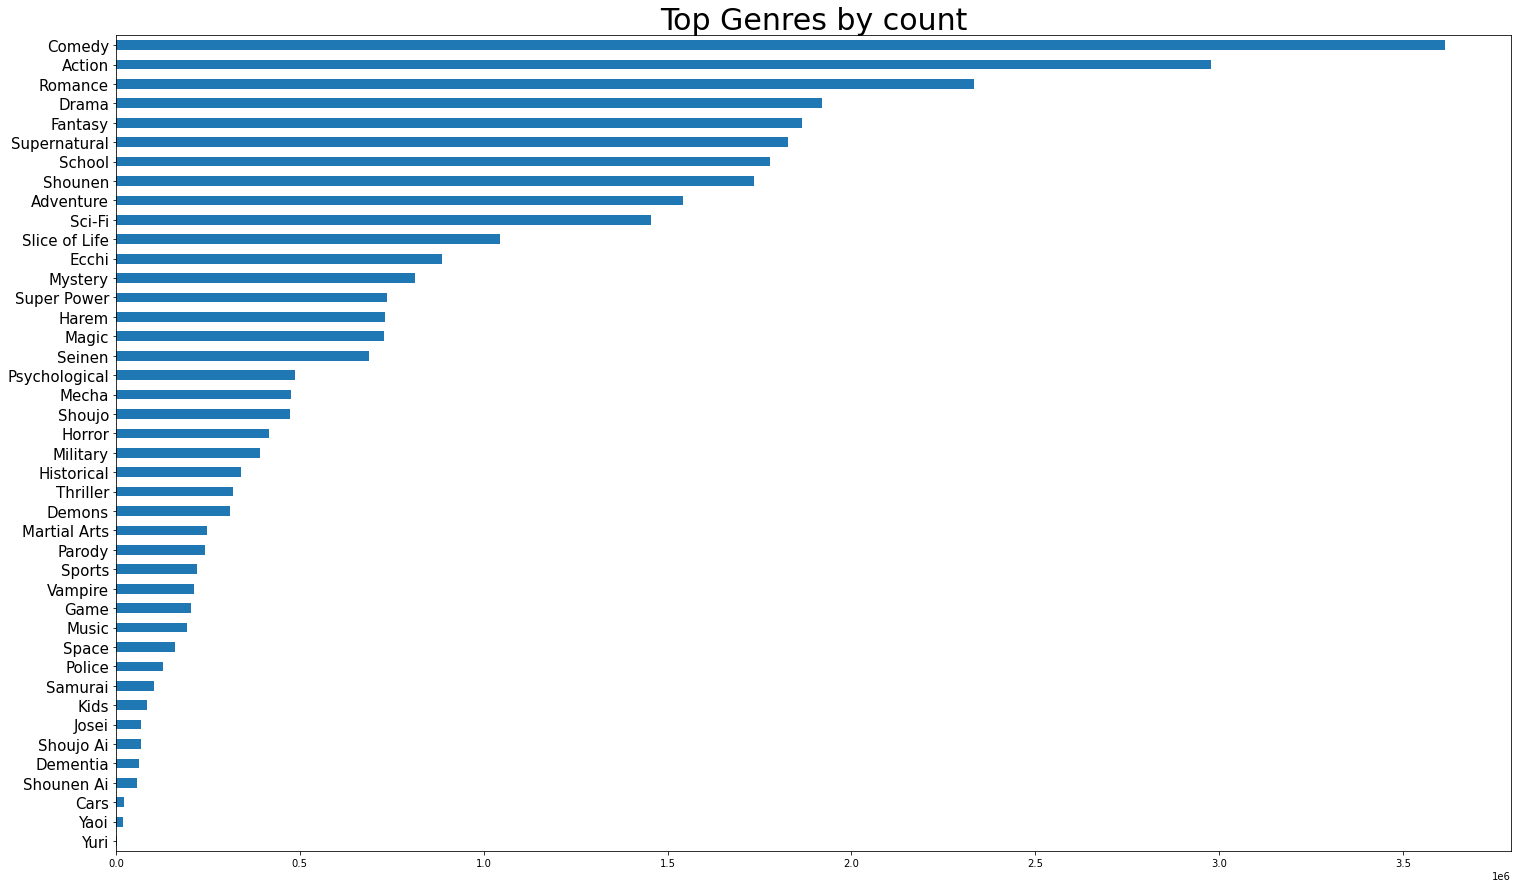

In [15]:
# Plotting top genres
exploded['genre'].value_counts(ascending = True).plot(kind='barh',figsize = (25,15))
plt.yticks(fontsize=15, rotation=0);
plt.title('Top Genres by count', fontsize = 30)

In [16]:
all_genres = defaultdict(int)

for genres in anime_comb['genre']:
    for genre in genres:
        all_genres[genre.strip()] += 1

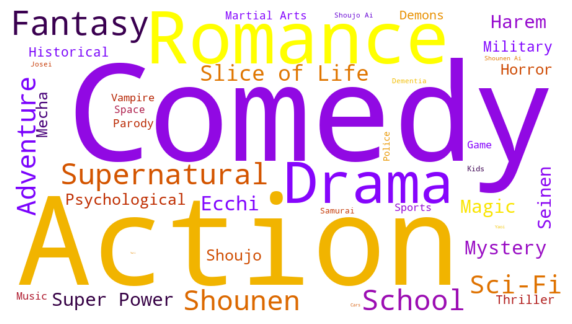

In [17]:
genres_cloud = WordCloud(width=900, height=500, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.figure(figsize = (10,8))
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Top genres are 'Comedy', 'Action', 'Adventure', 'Fantasy' and 'Sci-Fi'.

#### Type

Text(0.5, 1.0, 'Top types by count')

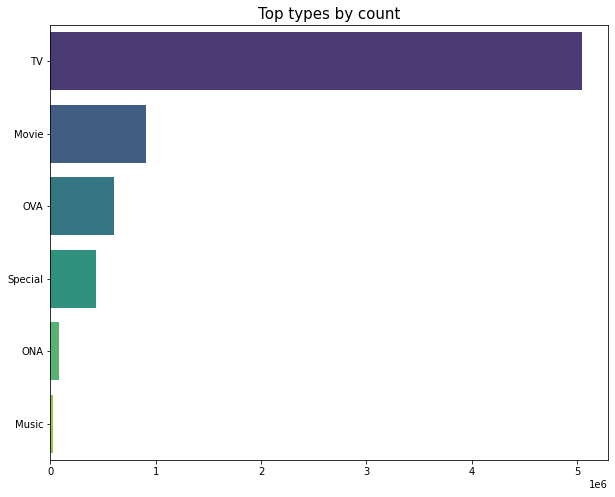

In [18]:
# Plotting top types of anime
types = anime_comb['type'].value_counts()
plt.figure(figsize = (10,8))

sns.barplot(x = types.values,
           y = types.index,
            data = anime,
            palette = 'viridis'
           )

plt.title('Top types by count', fontsize = 15)

'TV' has the most count under types and 'music' has the least.

<AxesSubplot:xlabel='type', ylabel='rating_x'>

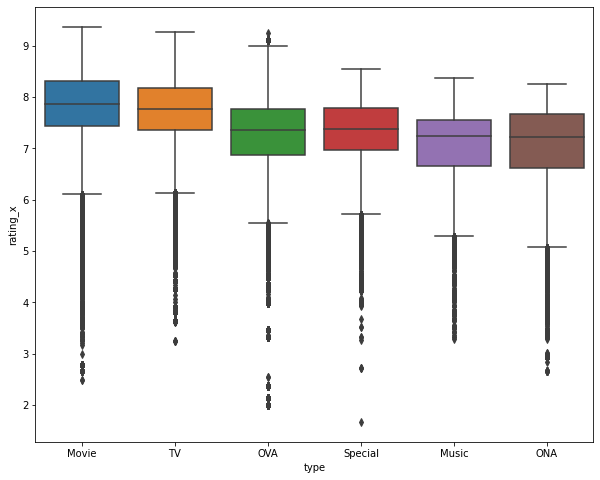

In [19]:
# Plotting types of animes of their ratings

plt.figure(figsize = (10,8))
sns.boxplot(data = anime_comb, y = 'rating_x', x = 'type')

There is no clear conclusion on what types have a higher rating.

#### Rating

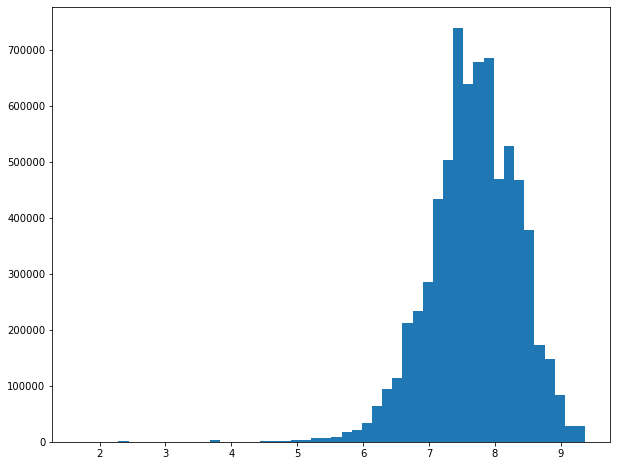

In [20]:
# Renaming user rating column
anime_comb = anime_comb.rename(columns = {'rating_y':'user_rating', 'rating_x':'rating'})

# PLotting histogram of rating
plt.figure(figsize = (10,8))
plt.hist(anime_comb['rating'], bins = 50);

Most animes's rating falls under the score of 6 to 8.

In [21]:
# Anime with highest rating
anime_comb.sort_values('rating', ascending = False)

,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1469,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,47529,9,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1463,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,47357,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1464,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,47372,9,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1465,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,47377,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7079818,34476,Platonic Chain: Ansatsu Jikkouchuu,"[Sci-Fi, Slice of Life]",Special,1,1.67,51,48766,-1,34476,Unknown,"Sci-Fi, Slice of Life","DVD-only story that replaces episode 16 (""Oyaj..."
7080886,30484,Steins;Gate 0,"[Sci-Fi, Thriller]",NaN,Unknown,NaN,60999,31437,9,30484,8.51,"Sci-Fi, Thriller","The eccentric, self-proclaimed mad scientist R..."
7080887,30484,Steins;Gate 0,"[Sci-Fi, Thriller]",NaN,Unknown,NaN,60999,37475,7,30484,8.51,"Sci-Fi, Thriller","The eccentric, self-proclaimed mad scientist R..."
7080888,30484,Steins;Gate 0,"[Sci-Fi, Thriller]",NaN,Unknown,NaN,60999,42372,9,30484,8.51,"Sci-Fi, Thriller","The eccentric, self-proclaimed mad scientist R..."


The highest rated animes may not be an accurate representation as there could be few total people who rated and have rated the anime highly.

In [22]:
anime_comb['user_id'].value_counts()

48766    8045
42635    3244
57620    2385
59643    2318
53698    2307
         ... 
56821       1
68032       1
43715       1
70956       1
59991       1
Name: user_id, Length: 73350, dtype: int64

In [23]:
# plt.figure(figsize = (10,8))
# plt.bar(anime_comb['user_rating'], height = anime_comb['user_rating'].max())

In [24]:
# Dropping rows with null ratings
#anime_comb[anime_comb['rating'].isnull()]

anime_comb = anime_comb.dropna (subset = ['rating'])
anime_comb.shape

(7101637, 13)

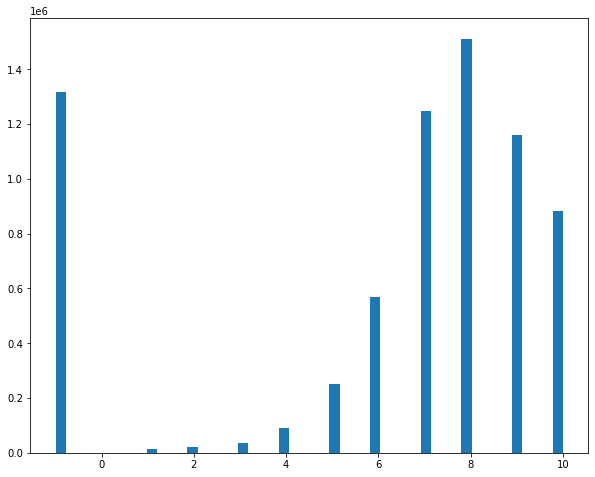

In [25]:
anime_comb['user_rating'].value_counts()

# Plotting histogram of user_rating
plt.figure(figsize = (10,8))
plt.hist(anime_comb['user_rating'], bins = 50);

According to data dictionary on Kaggle, a score of -1 means that user has watched anime but has not given a rating. Apart from that, animes that were rated tend to be rated from 7 to 8 the most.

In [26]:
anime_comb['user_rating'].value_counts()

 8     1512458
-1     1316308
 7     1247108
 9     1160458
 10     883291
 6      570328
 5      249644
 4       92161
 3       36186
 2       20007
 1       13688
Name: user_rating, dtype: int64

#### Episodes

In [27]:
# Drop rows with unknown episodes
anime_comb = anime_comb[anime_comb['episodes'] != 'Unknown']

In [28]:
anime_comb['episodes'].value_counts()

12     1678062
1      1449993
13      902462
24      511144
26      489250
        ...   
225          1
71           1
83           1
132          1
283          1
Name: episodes, Length: 176, dtype: int64

In [29]:
# Cleanup name column
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_comb['name'] = anime_comb['name'].apply(text_cleaning)

anime_comb

,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,271,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,278,-1,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103057,6546,Pico: My Little Summer Story,[Yaoi],OVA,1,5.21,5551,73389,6,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7103058,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,12431,3,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103059,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,27364,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7103060,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,48766,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."


In [30]:
# Drop rows with unknown episodes and convert column to int
anime_comb = anime_comb[anime_comb['episodes'] != 'Unknown']
anime_comb['episodes'] = anime_comb['episodes'].astype('int64')

# Reset index
anime_comb = anime_comb.reset_index(drop = True)

anime_comb

,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,271,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,278,-1,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7101629,6546,Pico: My Little Summer Story,[Yaoi],OVA,1,5.21,5551,73389,6,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7101630,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,12431,3,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7101631,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,27364,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7101632,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,48766,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."


In [31]:
anime_comb[anime_comb['episodes'] == 'Unknown']

,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis


In [32]:
anime_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7101634 entries, 0 to 7101633
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id_x   int64  
 1   name         object 
 2   genre        object 
 3   type         object 
 4   episodes     int64  
 5   rating       float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  int64  
 9   anime_id_y   int64  
 10  Score        object 
 11  Genres       object 
 12  synopsis     object 
dtypes: float64(1), int64(6), object(6)
memory usage: 704.4+ MB


## Content based Recommender

Content Based recommendation relies on similarity of recommended elements / features. The idea is that if you liked an item, you will also like other items with similar features. The content based recommendation approach solves the cold start problem encountered in the collaborative based problem. For example, if a new item comes into the market, users will not be recommended that item due to it not having being rated. With content based recommendation, the item will have a good score if it ranks highly in terms of similarity to previously used or liked products.

### TFIDF Vectorizer

One feature we will be basing our content based recommender on is the synopsis feature, the idea being that if a user liked an anime with a certain 'style' of synopsis, they will also like other anime titles with a very similar synopsis. To give a score to our synopsis feature, we will be using TFIDF Vectorizer, which takes into account the frequency and weight /'importance' of the word in the document.

The output is a matrix whereby each column represents a word / n-gram and each row represents an observation or in our case, an anime title. This is done to reduce the importance of frequently occurring words in the synopsis and therefore their relevance to the calculation of the final similarity score.

In [33]:
%%time

# Drop duplicate animes with same name and keep first occurence
anime_dup = anime_comb.drop_duplicates(subset = 'name', keep = 'first')
anime_dup = anime_dup.reset_index(drop = True)

synopsis_str = anime_dup['synopsis'].str.split(',').astype(str)

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 4), min_df = 3, stop_words = 'english')
tfidf_matrix = tfidf.fit_transform(synopsis_str)

tfidf_matrix.shape

# tfidf.get_feature_names()

Wall time: 3.72 s


(8844, 23217)

In [34]:
tfidf_matrix

<8844x23217 sparse matrix of type '<class 'numpy.float64'>'
	with 335051 stored elements in Compressed Sparse Row format>

In [35]:
tfidf.get_feature_names()

['00',
 '000',
 '000 000',
 '000 years',
 '000 years ago',
 '001',
 '007',
 '0079',
 '009',
 '01',
 '02',
 '03',
 '07',
 '09',
 '10',
 '10 000',
 '10 11',
 '10 minute',
 '10 minutes',
 '10 new',
 '10 new animated',
 '10 new animated versions',
 '10 year',
 '10 year old',
 '10 year old insect',
 '10 years',
 '10 years ago',
 '100',
 '100 000',
 '100 tv',
 '100 tv series',
 '100 years',
 '1000',
 '1000 years',
 '1001',
 '1001 nights',
 '100th',
 '100th anniversary',
 '101',
 '108',
 '108th',
 '10th',
 '10th anniversary',
 '10th anniversary event',
 '11',
 '11 12',
 '11 year',
 '11 year old',
 '11 years',
 '11th',
 '12',
 '12 000',
 '12 000 years',
 '12 year',
 '12 year old',
 '12 year old boy',
 '12 year old girl',
 '12 years',
 '12th',
 '12th birthday',
 '13',
 '13 14',
 '13 episode',
 '13 episodes',
 '13 included',
 '13 included blu',
 '13 included blu ray',
 '13 year',
 '13 year old',
 '13 year old boy',
 '13 years',
 '13 years old',
 '130',
 '13th',
 '13th episode',
 '13th episode tv

### Cosine Similarity

We will use cosine similarity to calculate a numerical value indicating the similarity between two anime. We use the cosine similarity index because it is magnitude independent and relatively easy and quick to calculate.

Cosine similarity takes the angle between two non-zero vectors and calculates the cosine of that angle, and this value is known as the similarity between the two vectors. This similarity score ranges from 0 to 1, where 0 is the lowest (least similar) and 1 is the highest (most similar). If the angle between two vectors is 0°, then the similarity will be 1. Conversely, if the angle between two vectors is 90°, then the similarity will be 0. For two vectors with an angle greater than 90°, we also consider them to be 0.

In [36]:
%%time
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim[:5, :5]

Wall time: 1.08 s


array([[1.        , 0.00536131, 0.01720987, 0.03505677, 0.00935462],
       [0.00536131, 1.        , 0.01010452, 0.00683776, 0.01263109],
       [0.01720987, 0.01010452, 1.        , 0.01135829, 0.00704835],
       [0.03505677, 0.00683776, 0.01135829, 1.        , 0.00874571],
       [0.00935462, 0.01263109, 0.00704835, 0.00874571, 1.        ]])

We now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 10 most similar movies based on the cosine similarity score.

In [37]:
cosine_sim.shape

(8844, 8844)

##### Synopsis based recommendations

In [38]:
indices = pd.Series(anime_dup.index, index=anime_dup['name'])
indices

name
Kimi no Na wa.                         0
Fullmetal Alchemist: Brotherhood       1
Gintama°                               2
Steins;Gate                            3
Hunter x Hunter (2011)                 4
                                    ... 
G-Taste (2010)                      8839
Kimera                              8840
Houkago no Shokuinshitsu            8841
Pico: My Little Summer Story        8842
Docchi mo Maid                      8843
Length: 8844, dtype: int64

In [39]:
def synop_recommendations(title):
    idx = indices[title]  # getting index corresponding with title
    sim_scores = list(enumerate(cosine_sim[idx]))  # get estimates of pairwise similarity of all animes with this anime
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # sorting from highest similarity score
    sim_scores = sim_scores[1:11]  # we use 1-11 as 0 will give us the anime that we have chosen
    
    anime_indices = [i[0] for i in sim_scores]  # get indexes
    similarity = [i[1] for i in sim_scores]
    
    return pd.DataFrame({'Anime name': anime_dup['name'].iloc[anime_indices].values,
                        'Similarity': similarity,
                         'Genre': anime_dup['genre'].iloc[anime_indices].values,
                        'Type': anime_dup['type'].iloc[anime_indices].values,
                        'Synopsis': anime_dup['synopsis'].iloc[anime_indices].values})  # displaying name, genre, type and synopsis

In [40]:
sim_scores = list(enumerate(cosine_sim[indices['Fullmetal Alchemist: Brotherhood']]))
sim_scores

[(0, 0.005361307896008072),
 (1, 1.0000000000000002),
 (2, 0.010104520224327137),
 (3, 0.006837763742110042),
 (4, 0.012631091249332508),
 (5, 0.01714923749096958),
 (6, 0.013074943857212149),
 (7, 0.007582411944943422),
 (8, 0.0),
 (9, 0.010272748781922886),
 (10, 0.01310472512368821),
 (11, 0.0034053185781120843),
 (12, 0.01019550146311137),
 (13, 0.007278434552286715),
 (14, 0.008753463522576476),
 (15, 0.014232402305218038),
 (16, 0.013929497140855313),
 (17, 0.008577572252985407),
 (18, 0.045621371087546096),
 (19, 0.014728070699820312),
 (20, 0.03094260921958333),
 (21, 0.0043682842774570825),
 (22, 0.008315549653366235),
 (23, 0.012207217332323085),
 (24, 0.004115026723865534),
 (25, 0.005550059912152957),
 (26, 0.0033574481258620316),
 (27, 0.002240276091875493),
 (28, 0.011207904537604653),
 (29, 0.008732842272050552),
 (30, 0.003921087220269416),
 (31, 0.004818243285841517),
 (32, 0.04056386173043398),
 (33, 0.008263380411784102),
 (34, 0.001969431985111023),
 (35, 0.04006367

In [41]:
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores

[(1, 1.0000000000000002),
 (172, 0.6216459208306828),
 (1337, 0.4343670948996234),
 (2067, 0.31990459781121483),
 (843, 0.3041729908565214),
 (346, 0.19684095091193646),
 (2253, 0.08774909763280399),
 (1490, 0.08732603570113348),
 (5522, 0.08011350606212647),
 (5001, 0.077854629460467),
 (7613, 0.07680885514095039),
 (6065, 0.07642392984336371),
 (2269, 0.07630981326881814),
 (6737, 0.06805815238576808),
 (2926, 0.06516309076401404),
 (2304, 0.06470641745361473),
 (4468, 0.06469985385765988),
 (1365, 0.06456392269514966),
 (2995, 0.06432689659914265),
 (2831, 0.06412762406163097),
 (4092, 0.0639805080912284),
 (623, 0.06366975743340897),
 (1702, 0.06093755373937857),
 (131, 0.06021327655998923),
 (567, 0.0587937939816614),
 (5002, 0.055402683838238036),
 (242, 0.05484953874106034),
 (3216, 0.054793433782732805),
 (8643, 0.05390834850769741),
 (5920, 0.052290702491166824),
 (3510, 0.05209102248277648),
 (6304, 0.05203645575756572),
 (5837, 0.051832312561693544),
 (6914, 0.05032957771796

In [42]:
%%time
synop_recommendations('Fullmetal Alchemist: Brotherhood')

Wall time: 9.97 ms


,Anime name,Similarity,Genre,Type,Synopsis
0,Fullmetal Alchemist,0.621646,"[Action, Adventure, Comedy, Drama, Fantasy...",TV,"Edward Elric, a young, brilliant alchemist, ha..."
1,Fullmetal Alchemist: The Sacred Star of Milos,0.434367,"[Action, Adventure, Comedy, Drama, Fantasy...",Movie,Chasing a runaway alchemist with strange power...
2,Fullmetal Alchemist: The Sacred Star of Milos ...,0.319905,"[Comedy, Fantasy, Magic]",ONA,To mark the July 2 opening of the Fullmetal Al...
3,Fullmetal Alchemist: The Conqueror of Shamballa,0.304173,"[Comedy, Drama, Fantasy, Historical, Milit...",Movie,"In desperation, Edward Elric sacrificed his bo..."
4,Fullmetal Alchemist: Brotherhood Specials,0.196841,"[Adventure, Drama, Fantasy, Magic, Militar...",Special,mazing secrets and startling facts are exposed...
5,Joker Game,0.087749,"[Drama, Historical, Military]",TV,"h World War II right around the corner, intell..."
6,Fullmetal Alchemist: Premium Collection,0.087326,"[Comedy, Fantasy, Shounen]",OVA,1. State Alchemists vs Seven Homunculi A 10 mi...
7,"Diabolik Lovers More,Blood",0.080114,"[Harem, School, Shoujo, Vampire]",TV,"Yui Komori, still held captive by the Sakamaki..."
8,Cowboy Bebop: Ein no Natsuyasumi,0.077855,[Adventure],Special,Corgi can certainly dream! Taking a break from...
9,Inferious Wakusei Senshi Gaiden Condition Green,0.076809,"[Action, Sci-Fi]",OVA,"Keith, George, Edward, Yang and Shaw are Plato..."


In [43]:
%%time
synop_recommendations('Death Note')

Wall time: 7.98 ms


,Anime name,Similarity,Genre,Type,Synopsis
0,Soul Eater,0.176649,"[Action, Adventure, Comedy, Fantasy, Shoun...",TV,Death City is home to the famous Death Weapon ...
1,Kite Liberator,0.168902,"[Action, Drama, Sci-Fi]",OVA,"In the previous series ""Kite,"" a killer—Sawa—s..."
2,YAT Anshin! Uchuu Ryokou 2,0.164707,"[Adventure, Comedy, Sci-Fi, Shounen]",TV,"The space travelling company, YAT, is thrown i..."
3,Yami no Matsuei,0.163860,"[Comedy, Drama, Fantasy, Horror, Magic, S...",TV,"Even after death, life is full of paperwork an..."
4,Bleach: Memories in the Rain,0.145748,"[Action, Adventure, Drama, Shounen, Supern...",Special,"Kurosaki Ichigo, the temporary Shinigami(Death..."
5,Medarot Damashii,0.139862,"[Action, Adventure, Sci-Fi]",TV,"The sequel to the famous Medabots series, foll..."
6,Yami no Shihosha Judge,0.133875,"[Horror, Seinen, Supernatural]",OVA,Hoichiro Ohma works in an office. Everybody kn...
7,Shinigami no Ballad.,0.132780,"[Drama, Fantasy, Psychological, Supernatural]",TV,"girl wrapped in white, her name is Momo...in h..."
8,Ghost Messenger,0.116069,"[Action, Fantasy]",OVA,Ghost Messengers are super-power agents from t...
9,Yume Senshi Wingman,0.115039,"[Action, Comedy, Romance, School, Super Po...",TV,Hirono Kenta is your average geeky junior high...


The score does not seem too well, especially for 'Death Note', with the top recommended anime only having 17% similarity in synopsis. We will include 'genre' as another one of our features and see if that improves the result. Perhaps more features such as voice actors/actresses will further improve the score.

##### Genre and synopsis based recommendations

Combining genres matrix with synopsis matrix

In [44]:
genres_str1 = anime_dup['genre'].astype(str)
# sypnopsis_str1 = anime_df['sypnopsis'].str.split(',').astype(str)
# unit =  pd.concat([sypnopsis_str1, genres_str1])

tfidf1 = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 1), min_df = 1)
tfidf_matrix1 = tfidf1.fit_transform(genres_str1)

tfidf_matrix1.shape

# # tfidf.get_feature_names()

(8844, 46)

In [45]:
tfidf1.get_feature_names()

['action',
 'adventure',
 'ai',
 'arts',
 'cars',
 'comedy',
 'dementia',
 'demons',
 'drama',
 'ecchi',
 'fantasy',
 'fi',
 'game',
 'harem',
 'historical',
 'horror',
 'josei',
 'kids',
 'life',
 'magic',
 'martial',
 'mecha',
 'military',
 'music',
 'mystery',
 'of',
 'parody',
 'police',
 'power',
 'psychological',
 'romance',
 'samurai',
 'school',
 'sci',
 'seinen',
 'shoujo',
 'shounen',
 'slice',
 'space',
 'sports',
 'super',
 'supernatural',
 'thriller',
 'vampire',
 'yaoi',
 'yuri']

In [46]:
genres_str1

0       ['Drama', ' Romance', ' School', ' Supernatural']
1       ['Action', ' Adventure', ' Drama', ' Fantasy',...
2       ['Action', ' Comedy', ' Historical', ' Parody'...
3                                 ['Sci-Fi', ' Thriller']
4       ['Action', ' Adventure', ' Shounen', ' Super P...
                              ...                        
8839                                   ['Ecchi', ' Yuri']
8840    ['Action', ' Horror', ' Sci-Fi', ' Supernatura...
8841                       ['Drama', ' Romance', ' Yaoi']
8842                                             ['Yaoi']
8843             ['Action', ' Comedy', ' Ecchi', ' Yuri']
Name: genre, Length: 8844, dtype: object

In [47]:
# Combining both dataframes
synop_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df = pd.DataFrame(tfidf_matrix1.toarray())
comb = pd.concat([synop_df, genre_df], axis = 1)
comb = csr_matrix(comb)
print(comb.shape)

(8844, 23263)


In [48]:
cosine_sim1 = cosine_similarity(comb, comb)
cosine_sim1[:5, :5]

array([[1.        , 0.07566103, 0.00860494, 0.01752839, 0.00467731],
       [0.07566103, 1.        , 0.09189383, 0.00341888, 0.17240756],
       [0.00860494, 0.09189383, 1.        , 0.11327186, 0.0986636 ],
       [0.01752839, 0.00341888, 0.11327186, 1.        , 0.00437286],
       [0.00467731, 0.17240756, 0.0986636 , 0.00437286, 1.        ]])

In [49]:
comb

<8844x23263 sparse matrix of type '<class 'numpy.float64'>'
	with 367674 stored elements in Compressed Sparse Row format>

In [50]:
def synop_genre_recommendations(title):
    idx = indices[title]  # getting index corresponding with title
    sim_scores = list(enumerate(cosine_sim1[idx]))  # get estimates of pairwise similarity of all animes with this anime
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # sorting from highest similarity score
    sim_scores = sim_scores[1:11]  # we use 1-11 as 0 will give us the anime that we have chosen
    
    anime_indices = [i[0] for i in sim_scores]  # get indexes
    similarity = [i[1] for i in sim_scores]
    
    return pd.DataFrame({'Anime name': anime_dup['name'].iloc[anime_indices].values,
                        'Similarity': similarity,
                         'Genre': anime_dup['genre'].iloc[anime_indices].values,
                        'Type': anime_dup['type'].iloc[anime_indices].values,
                        'Synopsis': anime_dup['synopsis'].iloc[anime_indices].values})  # displaying name, genre, type and synopsis

In [51]:
anime_comb[anime_comb['name'].str.match('Ouran')]

,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis
1000636,853,Ouran Koukou Host Club,"[Comedy, Harem, Romance, School, Shoujo]",TV,26,8.39,422271,11,7,853,8.2,"Comedy, Harem, Romance, School, Shoujo",Haruhi Fujioka is a bright scholarship candida...
1000637,853,Ouran Koukou Host Club,"[Comedy, Harem, Romance, School, Shoujo]",TV,26,8.39,422271,12,9,853,8.2,"Comedy, Harem, Romance, School, Shoujo",Haruhi Fujioka is a bright scholarship candida...
1000638,853,Ouran Koukou Host Club,"[Comedy, Harem, Romance, School, Shoujo]",TV,26,8.39,422271,18,8,853,8.2,"Comedy, Harem, Romance, School, Shoujo",Haruhi Fujioka is a bright scholarship candida...
1000639,853,Ouran Koukou Host Club,"[Comedy, Harem, Romance, School, Shoujo]",TV,26,8.39,422271,20,10,853,8.2,"Comedy, Harem, Romance, School, Shoujo",Haruhi Fujioka is a bright scholarship candida...
1000640,853,Ouran Koukou Host Club,"[Comedy, Harem, Romance, School, Shoujo]",TV,26,8.39,422271,21,8,853,8.2,"Comedy, Harem, Romance, School, Shoujo",Haruhi Fujioka is a bright scholarship candida...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019695,853,Ouran Koukou Host Club,"[Comedy, Harem, Romance, School, Shoujo]",TV,26,8.39,422271,73497,10,853,8.2,"Comedy, Harem, Romance, School, Shoujo",Haruhi Fujioka is a bright scholarship candida...
1019696,853,Ouran Koukou Host Club,"[Comedy, Harem, Romance, School, Shoujo]",TV,26,8.39,422271,73500,9,853,8.2,"Comedy, Harem, Romance, School, Shoujo",Haruhi Fujioka is a bright scholarship candida...
1019697,853,Ouran Koukou Host Club,"[Comedy, Harem, Romance, School, Shoujo]",TV,26,8.39,422271,73504,9,853,8.2,"Comedy, Harem, Romance, School, Shoujo",Haruhi Fujioka is a bright scholarship candida...
1019698,853,Ouran Koukou Host Club,"[Comedy, Harem, Romance, School, Shoujo]",TV,26,8.39,422271,73507,10,853,8.2,"Comedy, Harem, Romance, School, Shoujo",Haruhi Fujioka is a bright scholarship candida...


In [52]:
synop_genre_recommendations('Ouran Koukou Host Club')

,Anime name,Similarity,Genre,Type,Synopsis
0,Uta no☆Prince-sama♪ Maji Love 1000%,0.470451,"[Comedy, Harem, Music, Romance, School, S...",TV,"Haruka Nanami, an aspiring composer from the c..."
1,Uta no☆Prince-sama♪ Maji Love 2000%,0.459365,"[Comedy, Harem, Music, Romance, School, S...",TV,"Entering her Master's course, Nanami Haruka is..."
2,Starry☆Sky,0.456212,"[Harem, School, Shoujo]",ONA,"The protagonist, Tsukiko Yahisa, enrolled to a..."
3,Uta no☆Prince-sama♪ Maji Love Revolutions,0.455741,"[Comedy, Harem, Music, Romance, School, S...",TV,The third anime adaptation of the otome game U...
4,Daitoshokan no Hitsujikai,0.453167,"[Harem, Romance, School]",TV,"""The Shepherd,"" an urban legend of Shiomi Acad..."
5,Uta no☆Prince-sama♪ Maji Love 2000%: Shining S...,0.452769,"[Comedy, Harem, Music, Romance, School, S...",Special,Unaired episode included in the seventh Blu-ra...
6,Aishen Qiaokeli-ing...,0.452677,"[Comedy, Harem, Romance, School]",ONA,"Jiang Hao Yi, a normal, high school student wh..."
7,Happy☆Lesson,0.451627,"[Comedy, Harem, Romance, School]",OVA,One guy. Five girls. One roof. It's a recycled...
8,Kiniro no Corda: Primo Passo - Hitonatsu no En...,0.443068,"[Harem, Music, Romance, School, Shoujo]",Special,Hino Kahoko goes to a summer training camp to ...
9,Akaneiro ni Somaru Saka,0.442686,"[Comedy, Harem, Romance, School]",TV,Yuuhi Katagiri is not your average girl – she'...


In [53]:
synop_genre_recommendations('Fullmetal Alchemist: Brotherhood')

,Anime name,Similarity,Genre,Type,Synopsis
0,Fullmetal Alchemist,0.797745,"[Action, Adventure, Comedy, Drama, Fantasy...",TV,"Edward Elric, a young, brilliant alchemist, ha..."
1,Fullmetal Alchemist: The Sacred Star of Milos,0.704106,"[Action, Adventure, Comedy, Drama, Fantasy...",Movie,Chasing a runaway alchemist with strange power...
2,Fullmetal Alchemist: Brotherhood Specials,0.576796,"[Adventure, Drama, Fantasy, Magic, Militar...",Special,mazing secrets and startling facts are exposed...
3,Fullmetal Alchemist: The Conqueror of Shamballa,0.479923,"[Comedy, Drama, Fantasy, Historical, Milit...",Movie,"In desperation, Edward Elric sacrificed his bo..."
4,Tales of Vesperia: The First Strike,0.443175,"[Action, Adventure, Fantasy, Magic, Military]",Movie,Ten years after the Great War against the demo...
5,Tide-Line Blue,0.426710,"[Action, Adventure, Drama, Military, Shounen]",TV,"The catastrophe, ""Hammer of Eden,"" resulted in..."
6,Fullmetal Alchemist: The Sacred Star of Milos ...,0.416856,"[Comedy, Fantasy, Magic]",ONA,To mark the July 2 opening of the Fullmetal Al...
7,Fullmetal Alchemist: Reflections,0.406139,"[Adventure, Comedy, Drama, Fantasy, Milita...",Special,flection on what happened during the FMA TV se...
8,Magi: Sinbad no Bouken (TV),0.399622,"[Action, Adventure, Fantasy, Magic, Shounen]",TV,"In the small, impoverished Tison Village of th..."
9,Fairy Tail Movie 1: Houou no Miko,0.399445,"[Action, Adventure, Comedy, Fantasy, Magic...",Movie,In the mountains of north Fiore lies the Fire ...


In [54]:
synop_genre_recommendations('Death Note')

,Anime name,Similarity,Genre,Type,Synopsis
0,Mousou Dairinin,0.502951,"[Drama, Mystery, Police, Psychological, Su...",TV,The infamous Shounen Bat (Lil' Slugger) is ter...
1,Higurashi no Naku Koro ni Kai,0.439441,"[Mystery, Psychological, Supernatural, Thri...",TV,"In the small village of Hinamizawa, Rika Furud..."
2,Higurashi no Naku Koro ni Rei,0.435465,"[Comedy, Mystery, Psychological, Supernatur...",OVA,The infamous series of unexplainable murders i...
3,Monster,0.410825,"[Drama, Horror, Mystery, Police, Psycholog...",TV,"Dr. Kenzou Tenma, an elite neurosurgeon recent..."
4,Higurashi no Naku Koro ni,0.404385,"[Horror, Mystery, Psychological, Supernatur...",TV,Keiichi Maebara has just moved to the quiet li...
5,Mirai Nikki (TV): Ura Mirai Nikki,0.399226,"[Action, Comedy, Mystery, Psychological, S...",Special,"Unaired ""Ura Mirai Nikki"" anime (the short epi..."
6,AD Police,0.389150,"[Adventure, Dementia, Mecha, Mystery, Poli...",OVA,"The year is 2027 in MegaTokyo, six years befor..."
7,Imawa no Kuni no Alice (OVA),0.383433,"[Action, Psychological, Shounen, Supernatur...",OVA,ouhei Arisu is a high school student with no a...
8,Shigofumi,0.383216,"[Drama, Fantasy, Psychological, Supernatura...",TV,There are some things that people are unable t...
9,Zankyou no Terror,0.380111,"[Psychological, Thriller]",TV,"Painted in red, the word ""VON"" is all that is ..."


In [55]:
synop_genre_recommendations('Sword Art Online')

,Anime name,Similarity,Genre,Type,Synopsis
0,Sword Art Online: Extra Edition,0.698663,"[Action, Adventure, Fantasy, Game, Romance]",Special,The story is set a couple of years after the e...
1,Sword Art Online II,0.679740,"[Action, Adventure, Fantasy, Game, Romance]",TV,"ar after escaping Sword Art Online, Kazuto Kir..."
2,Ys IV: The Dawn of Ys,0.473313,"[Action, Adventure, Fantasy, Game]",Special,This was an animated promotional video that Fa...
3,Bakugan Battle Brawlers: Mechtanium Surge,0.468900,"[Action, Adventure, Fantasy, Game, Shounen]",TV,fter returning from the feuding realms of Gund...
4,"Slime Boukenki: Umi da, Yeah!",0.466622,"[Action, Adventure, Comedy, Fantasy, Game]",Special,short anime directed by Yuasa Masaaki with Pro...
5,Bakugan Battle Brawlers,0.465939,"[Action, Fantasy, Game]",TV,sterious cards came down from the sky one day....
6,Sword Art Online II: Debriefing,0.457403,"[Action, Adventure, Fantasy, Game]",Special,"cap episode of the Phantom Bullet arc, also kn..."
7,Card Wang: Mix Master,0.455425,"[Adventure, Fantasy, Game, Shounen]",TV,x Masters is a Korea-Japan co-produced anime s...
8,Bakugan Battle Brawlers: Gundalian Invaders,0.454298,"[Action, Adventure, Fantasy, Game, Shounen]",TV,Bakugan Interspace is a virtual reality system...
9,Monster Strike,0.447403,"[Action, Fantasy, Game]",ONA,Homura has just moved back to his hometown of ...


In [56]:
synop_genre_recommendations('Sword Art Online')

,Anime name,Similarity,Genre,Type,Synopsis
0,Sword Art Online: Extra Edition,0.698663,"[Action, Adventure, Fantasy, Game, Romance]",Special,The story is set a couple of years after the e...
1,Sword Art Online II,0.679740,"[Action, Adventure, Fantasy, Game, Romance]",TV,"ar after escaping Sword Art Online, Kazuto Kir..."
2,Ys IV: The Dawn of Ys,0.473313,"[Action, Adventure, Fantasy, Game]",Special,This was an animated promotional video that Fa...
3,Bakugan Battle Brawlers: Mechtanium Surge,0.468900,"[Action, Adventure, Fantasy, Game, Shounen]",TV,fter returning from the feuding realms of Gund...
4,"Slime Boukenki: Umi da, Yeah!",0.466622,"[Action, Adventure, Comedy, Fantasy, Game]",Special,short anime directed by Yuasa Masaaki with Pro...
5,Bakugan Battle Brawlers,0.465939,"[Action, Fantasy, Game]",TV,sterious cards came down from the sky one day....
6,Sword Art Online II: Debriefing,0.457403,"[Action, Adventure, Fantasy, Game]",Special,"cap episode of the Phantom Bullet arc, also kn..."
7,Card Wang: Mix Master,0.455425,"[Adventure, Fantasy, Game, Shounen]",TV,x Masters is a Korea-Japan co-produced anime s...
8,Bakugan Battle Brawlers: Gundalian Invaders,0.454298,"[Action, Adventure, Fantasy, Game, Shounen]",TV,Bakugan Interspace is a virtual reality system...
9,Monster Strike,0.447403,"[Action, Fantasy, Game]",ONA,Homura has just moved back to his hometown of ...


In [57]:
synop_genre_recommendations('White Album 2nd Season')

,Anime name,Similarity,Genre,Type,Synopsis
0,White Album,0.548022,"[Drama, Harem, Music, Romance]",TV,Can a relationship between a regular college s...
1,_Summer,0.431759,"[Drama, Harem, Romance]",OVA,“Is there any girl you love?” By this word his...
2,Mashiro-iro Symphony: The Color of Lovers Pict...,0.431759,"[Drama, Harem, Romance]",Special,DVD/BD specials of Mashiroiro Symphony: The Co...
3,Kiniro no Corda: Primo Passo - Hitonatsu no En...,0.415492,"[Harem, Music, Romance, School, Shoujo]",Special,Hino Kahoko goes to a summer training camp to ...
4,Lovedol: Lovely Idol,0.411265,"[Harem, Music]",TV,"ovedol, or Lovely Idol, is a girl group consis..."
5,D.C.II S.S.: Da Capo II Second Season,0.405939,"[Comedy, Drama, Fantasy, Harem, Romance]",TV,The story continues where it left off at seaso...
6,White Album 2,0.391441,"[Drama, Music, Romance, Slice of Life]",TV,Haruki Kitahara's light music club is on the v...
7,School Days,0.389048,"[Drama, Harem, Romance, School]",TV,High school student Makoto Itou first notices ...
8,To Heart 2 Adnext,0.387467,"[Comedy, Harem, Romance]",OVA,The first and the second volume will feature K...
9,Mashiro-iro Symphony: Airi ga Anata no Kanojo ...,0.387126,"[Harem, Romance]",Special,alternate ending to the anime with Airi being ...


In [58]:
synop_genre_recommendations('Clannad: After Story')

,Anime name,Similarity,Genre,Type,Synopsis
0,Clannad,0.573885,"[Comedy, Drama, Romance, School, Slice of ...",TV,Tomoya Okazaki is a delinquent who finds life ...
1,Air,0.483952,"[Drama, Romance, Slice of Life, Supernatural]",TV,Yukito Kunisaki is on a journey in search of t...
2,Sola,0.483276,"[Drama, Romance, Slice of Life, Supernatural]",TV,Yorito Morimiya is obsessed with the sky. He e...
3,Kanon,0.475914,"[Drama, Romance, Slice of Life, Supernatural]",TV,It’s been 7 years since Yuuichi Aizawa visited...
4,Kanon (2006),0.472865,"[Drama, Romance, Slice of Life, Supernatural]",TV,"s a young child, Aizawa Yuuichi had often visi..."
5,Kanon Kazahana,0.472865,"[Drama, Romance, Slice of Life, Supernatural]",Special,The spring has come since Yuuichi reunited wit...
6,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen",0.461882,"[Drama, Romance, School, Slice of Life]",Special,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen is s..."
7,Colorful (Movie),0.453549,"[Drama, Slice of Life, Supernatural]",Movie,"Upon arriving at the train station of death, a..."
8,Natsume Yuujinchou,0.453490,"[Drama, Fantasy, Shoujo, Slice of Life, Su...",TV,"hile most fifteen-year-old boys, in one way or..."
9,Glasslip,0.451975,"[Romance, Slice of Life, Supernatural]",TV,hat if you hold the power to hear the voices o...


In [59]:
synop_genre_recommendations('Shaman King')

,Anime name,Similarity,Genre,Type,Synopsis
0,Shaman King Specials,0.565110,"[Action, Comedy, Shounen, Supernatural]",Special,"Throughout the broadcast of Shaman King, many ..."
1,Bleach: Memories in the Rain,0.478442,"[Action, Adventure, Drama, Shounen, Supern...",Special,"Kurosaki Ichigo, the temporary Shinigami(Death..."
2,Gensoumaden Saiyuuki,0.469064,"[Adventure, Comedy, Drama, Shounen, Supern...",TV,"any years ago, humans and demons lived in harm..."
3,Yuu☆Yuu☆Hakusho: Eizou Hakusho II,0.454834,"[Action, Adventure, Comedy, Shounen, Super...",OVA,Eizou Hakusho II actually consists of four sep...
4,Tokyo Juushouden,0.443356,"[Action, Adventure, Shounen, Supernatural]",OVA,"ong ago, in feudal Japan, there was a fierce w..."
5,Tokyo Juushouden: Fuuma Gogyou Denshou,0.443356,"[Action, Adventure, Shounen, Supernatural]",OVA,"ong ago, in feudal Japan, there was a fierce w..."
6,Bleach Movie 2: The DiamondDust Rebellion - Mo...,0.439718,"[Action, Adventure, Shounen, Supernatural]",Movie,ssigned to protect a royal procession transpor...
7,Juubee-chan: Lovely Gantai no Himitsu,0.438998,"[Action, Adventure, Comedy, Drama, Shounen]",TV,Jiyu Nanohana is an ordinary schoolgirl until ...
8,Noragami,0.436928,"[Action, Adventure, Shounen, Supernatural]",TV,"In times of need, if you look in the right pla..."
9,Naruto Movie 2: Dai Gekitotsu! Maboroshi no Ch...,0.432703,"[Adventure, Comedy, Drama, Fantasy, Shoune...",Movie,"Naruto, Shikamaru, and Sakura are executing th..."


We see that by adding genre to the list of features, the similarity score has improved. The anime recommendations also seemed better. But one shortcoming of content based recommender is that it does not take into account user ratings when recommending anime titles, hence we will look into another approach when doing recommender systems, the collaborative based filtering approach.

## Collaborative based Filtering
- Surprise library
    - Memory Based (KNNBasic, KNNWithMeans)
    - Model Based (BaselineOnly, SVD, SVDpp, NMF)

In [60]:
# Making copy of anime_comb
anime_feature = anime_comb.copy()

# Filling -1 user ratings scores as null
anime_feature["user_rating"].replace({-1: np.nan}, inplace=True)
anime_feature.head()

,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,271,10.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,278,NaN,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."


In [61]:
#Filtering out users who have given more than or equal to 200 ratings
counts = anime_feature['user_id'].value_counts()
anime_feature = anime_feature[anime_feature['user_id'].isin(counts[counts >= 200].index)]

In [62]:
# Dropping nulls since to reduce size of dataset since rows without ratings does not help with recommendation
anime_feature = anime_feature.dropna(axis = 0, how ='any') 
anime_feature.isnull().sum()

anime_id_x     0
name           0
genre          0
type           0
episodes       0
rating         0
members        0
user_id        0
user_rating    0
anime_id_y     0
Score          0
Genres         0
synopsis       0
dtype: int64

In [63]:
# To try with out dropping na (see previous cell)

In [64]:
anime_feature['user_rating'].value_counts()

8.0     756451
7.0     672569
9.0     496660
10.0    326277
6.0     326078
5.0     145887
4.0      54490
3.0      22051
2.0      11565
1.0       7830
Name: user_rating, dtype: int64

In [65]:
def precision_recall_at_k(predictions, k=10, threshold= 7):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    # Predictions: Traz uma lista de 5 campos dentro de uma tupla com as seguintes infos: User_ID, Item_ID, True_ID, Est_ID, Details
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    # Creates a dict with the key being a user and the value bringing the estimated rating and the true rating.

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k /  n_rel if n_rel != 0 else 1

    return precisions, recalls

In [66]:
# Define reader
reader = Reader(rating_scale=(1, 10))

# Reducing number of rows for surprise library to random 50_000 rows
surprise_rating_df = anime_feature.sample(n = 100_000, random_state = 42)  # Test for higher number?
surprise_rating_df

# Match user_id, anime_id and ratings in order
data = Dataset.load_from_df(surprise_rating_df[['user_id', 'anime_id_x', 'user_rating']], reader)

# Building train and test set using data
# trainset = data.build_full_trainset()
# testset = trainset.build_anti_testset()  # predict ratings for all pairs that are NOT in the training set

# analysis = defaultdict(list)

#### Default test on train_test set

In [67]:
%%time
trainset = data.build_full_trainset()
testset = trainset.build_testset()

for algo in [BaselineOnly(), SVD(), SVDpp(), NMF(), KNNBasic(), KNNWithMeans()]:
    # Perform cross validation
    algo.fit(trainset)
    #results = cross_validate(algo, data, measures=['RMSE','MAE'], cv = 5, verbose=False)

    # testset = trainset.build_testset()
    predictions = algo.test(testset)
    
    # RMSE should be low as we are biased
    accuracy.rmse(predictions, verbose=True) 
    
# testset = trainset.build_testset()
# predictions = algo.test(testset)
    # RMSE should be low as we are biased
    accuracy.rmse(predictions, verbose=True)  # ~ 0.68 (which is low)

Estimating biases using als...
RMSE: 1.2226
RMSE: 1.2226
RMSE: 0.8597
RMSE: 0.8597
RMSE: 0.8698
RMSE: 0.8698
RMSE: 1.7911
RMSE: 1.7911
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5450
RMSE: 0.5450
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7181
RMSE: 0.7181
Wall time: 1min 12s


In [68]:
predictions

[Prediction(uid=47592, iid=5079, r_ui=7.0, est=6.641835625513009, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=47592, iid=1015, r_ui=9.0, est=7.9939357192957345, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=47592, iid=7590, r_ui=4.0, est=5.366284426790287, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=47592, iid=1195, r_ui=8.0, est=7.1681301849189145, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=47592, iid=226, r_ui=8.0, est=7.305653488259102, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=47592, iid=3467, r_ui=6.0, est=6.175790757681059, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=7438, iid=3342, r_ui=6.0, est=5.083084402716426, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=7438, iid=3759, r_ui=4.0, est=3.641841590943222, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=7438, iid=3457, r_ui=7.0, est=5.087850951

In [69]:
%%time
benchmark = []
# Iterate over all algorithms
for algo in [BaselineOnly(), SVD(), SVDpp(), NMF(), KNNBasic(), KNNWithMeans()]:
    # Perform cross validation
    results = cross_validate(algo, data, measures=['RMSE','MAE'], cv = 5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Wall time: 3min 12s


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,1.291232,0.985238,19.006272,0.423452
SVD,1.296970,0.990106,4.248610,0.123473
BaselineOnly,1.318569,1.009263,0.325522,0.096944
KNNWithMeans,1.469163,1.115261,2.531220,1.344981
KNNBasic,1.651413,1.263632,2.297255,1.376740
NMF,2.233186,1.922657,5.531937,0.109344


In [70]:
anime_feature['user_rating'].value_counts()

8.0     756451
7.0     672569
9.0     496660
10.0    326277
6.0     326078
5.0     145887
4.0      54490
3.0      22051
2.0      11565
1.0       7830
Name: user_rating, dtype: int64

In [71]:
surprise_rating_df['user_rating'].value_counts()

8.0     26799
7.0     23937
9.0     17524
10.0    11726
6.0     11559
5.0      5121
4.0      1858
3.0       804
2.0       405
1.0       267
Name: user_rating, dtype: int64

(array([  267.,   405.,   804.,  1858.,  5121., 11559., 23937., 26799.,
        17524., 11726.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

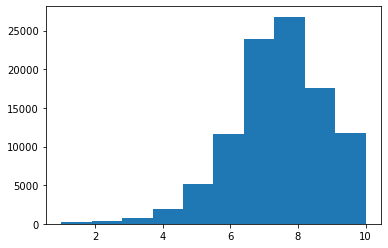

In [72]:
plt.hist(surprise_rating_df['user_rating'], bins = 10)

### Memory Based

#### KNNBasic (GridsearchCV)

As the format of trainset in surprise recommender library is different from our dataset, we will be using gridsearch on our dataset instead of using train_test_split. 
- https://github.com/NicolasHug/Surprise/issues/190

In [73]:
%%time
# GridSearchCV with KNNBasic

param_grid = {'k':[5,10], 
              'k-int': [3, 5],
             }

# sim_options = {'name': 'pearson', 'user_based':True}

gs1 = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv = 5)

gs1.fit(data)

# best RMSE score
print(gs1.best_score)#['rmse'])

# parameters with best rmse score
print(gs1.best_params)#['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [74]:
for algo in [BaselineOnly(), SVD(), SVDpp(), NMF(), KNNBasic(), KNNWithMeans()]:
    # Perform cross validation
    algo.fit(trainset)
    #results = cross_validate(algo, data, measures=['RMSE','MAE'], cv = 5, verbose=False)

    # testset = trainset.build_testset()
    predictions = algo.test(testset)
    
    # RMSE should be low as we are biased
    accuracy.rmse(predictions, verbose=True) 

Estimating biases using als...
RMSE: 1.2226
RMSE: 0.8567
RMSE: 0.8703
RMSE: 1.7927
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5450
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7181


#### KNNWithMeans

Recommendation System

Building recommendation system to scale using scikit-surprise (surprise library)

[Recommender systems](https://en.wikipedia.org/wiki/Recommender_system) are one of the most common used and easily understandable applications of data science. Lots of work has been done on this topic, the interest and demand in this area remains very high because of the rapid growth of the internet and the information overload problem. It has become necessary for online businesses to help users to deal with information overload and provide personalized recommendations, content and services to them.

Two of the most popular ways to approach recommender systems are [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) and [content-based recommendations](https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/). In this post, we will focus on the **collaborative filtering** approach, that is: the user is recommended items that people with similar tastes and preferences liked in the past. In another word, this method predicts unknown ratings by using the similarities between users.

In [75]:
# Dropping nulls since to reduce size of dataset since rows without ratings does not help with recommendation
# anime_feature = anime_feature.dropna(axis = 0, how ='any') 
# anime_feature.isnull().sum()

In [76]:
%%time
# GridSearchCV with KNNBasic

# param_grid = {'k':[5,10], 
#               'k-int': [3, 5],
#              }

param_grid = {'k': [10, 20],
              'k-int':[3, 5],
              'sim_options': {'name': ['pearson', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [True]}
              }
# sim_options = {'name': 'pearson', 'user_based':True}

gs2 = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv = 5)

gs2.fit(data)

# best RMSE score
print(gs2.best_score)#['rmse'])

# parameters with best rmse score
print(gs2.best_params)#['rmse'])

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Co

In [77]:
# Creating sparse matrix of 'user_id' and 'name' 
anime_pivot = anime_feature.pivot_table(index = 'name', columns = 'user_id', values = 'user_rating').fillna(0)
anime_pivot.head()

user_id        5      7      17     38     43     46     123    129    139    \
name                                                                           
001              0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009 Re:Cyborg    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009-1            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
00:08            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
07-Ghost         0.0    0.0    0.0    0.0    0.0    8.0    7.0    0.0    0.0   

user_id        160    198    210    226    232    233    235    244    248    \
name                                                                           
001              0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009 Re:Cyborg    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009-1            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
00:08            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
07-Ghost         0.0    0.0    0.0    7.0    0.0    0.0    7.0    0.0    0.0   

user_id        250    256    261    270    271    282    288    294    296    \
name                                                                           
001              0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009 Re:Cyborg    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009-1            0.0    0.0    0.0    0.0    0.0    0.0    6.0    0.0    0.0   
00:08            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
07-Ghost         0.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0    0.0   

user_id        308    317    321    326    342    352    373    375    385    \
name                                                                           
001              0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009 Re:Cyborg    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009-1            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
00:08            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
07-Ghost         0.0    0.0    0.0    0.0    0.0    5.0    0.0    0.0   10.0   

user_id        392    395    418    428    431    435    436    438    439    \
name                                                                           
001              0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009 Re:Cyborg    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009-1            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
00:08            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
07-Ghost         6.0    0.0    0.0    8.0    0.0    0.0    0.0    0.0    6.0   

user_id        446    447    455    460    462    478    492    497    500    \
name                                                                           
001              0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009 Re:Cyborg    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009-1            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
00:08            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
07-Ghost         5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

user_id        511    529    530    540    541    547    551    552    553    \
name                                                                           
001              0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009 Re:Cyborg    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
009-1            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
00:08            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
07-Ghost         0.0    0.0    0.0    7.0    0.0    0.0    0.0    0.0    9.0   

user_id        565    567    572    573    578    585    593    598    61

In [78]:
anime_pivot.shape

(7728, 9413)

In [79]:
# Instantiate knn model
# anime_matrix = csr_matrix(anime_pivot.values)  # anime, user_id

# Fitting matrix
# knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
# knn_model.fit(anime_matrix)

In [80]:
# indices_mat = pd.Series(anime_pivot.reset_index().index, index = anime_pivot.index)
# indices_mat

In [81]:
# anime_comb[anime_comb['name'] == '001']

In [82]:
# new_pivot = anime_pivot.reset_index()
# new_pivot.head()

In [83]:
# Function for knn recommender model for top 10 recommendations

# def knn_recommender(title):
#     query_index = indices_mat[title]
#     distances, indices = knn_model.kneighbors(anime_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 11)
    
#     for i in range(0, len(distances.flatten())):
#         if i == 0:
#             print('Recommendations for {0}:\n'.format(anime_pivot.index[query_index]))
#         else:
#             print('{0}: {1}, with distance of {2}:'.format(i, anime_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
    

In [84]:
# knn_recommender('Fullmetal Alchemist: Brotherhood')

In [85]:
# knn_recommender('Death Note')

Comment here

### Model Based - Surprise Library

In [86]:
# Reduciong number of rows for surprise library to random 50_000 rows
# surprise_rating_df = anime_feature.sample(n = 50_000)  # Test for higher number?
# surprise_rating_df

In [87]:
# Modifying data in a way that surprise can understand
# Converting user_rating to int format
# surprise_rating_df['user_rating'] = surprise_rating_df['user_rating'].astype(int)

#### KNN models

KNN Basic

In [88]:
# %%time

# param_grid = {'k':[5,10], 
#               'k-int': [3, 5], 
#              }

# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv = 5)

# gs.fit(data)

# # best RMSE score
# print(gs.best_score['rmse'])

# # parameters with best rmse score
# print(gs.best_params['rmse'])

In [89]:
# %%time
# # Define reader
# reader = Reader(rating_scale=(0, 10))

# # Match user_id, anime_id and ratings in order
# data = Dataset.load_from_df(surprise_rating_df[['user_id', 'anime_id_x', 'user_rating']], reader)

# # Instantiate SVD
# algo = SVD()

# # Display results with 5-fold cross validation
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv = 5, verbose=True)

#### Matrix Factorization models

Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices.

In [106]:
%%time

# param_grid = {'n_factors':[20,50],
#               'n_epochs': [15, 30],
#               'lr_all': [0.005, 0.01],
#               'reg_all': [0.4, 0.5]}

param_grid = {'bsl_options':{'method': ['als', 'sgd'],
                             'n_epochs': [5, 10],
                             'reg_u': [12],
                             'reg_i': [5],
                            'lr_all':[0.005, 0.01],
                            'reg_all':[0.04, 0.05]}
               }
                             

gs3 = GridSearchCV(BaselineOnly, param_grid,  measures=['rmse', 'mae'], cv = 5)

gs3.fit(data)

# best RMSE score
print(gs3.best_score)#['rmse'])

# parameters with best rmse score
print(gs3.best_params)#['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [91]:
%%time

param_grid = {'n_factors':[20,50], 'n_epochs': [30, 50], 'lr_all': [0.005, 0.01], 'reg_all': [0.4, 0.5]}

gs4 = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv = 5)

gs4.fit(data)

# best RMSE score
print(gs4.best_score['rmse'])

# parameters with best rmse score
print(gs4.best_params['rmse'])

1.2775350718133796
{'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.4}
Wall time: 6min 27s


In [92]:
# %%time

# param_grid = {'n_factors':[20,50], 'n_epochs': [30, 50], 'lr_all': [0.005, 0.01], 'reg_all': [0.4, 0.5]}

# gs5 = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv = 5)

# gs5.fit(data)

# # best RMSE score
# print(gs5.best_score['rmse'])

# # parameters with best rmse score
# print(gs5.best_params['rmse'])

KeyboardInterrupt: 

In [105]:
%%time

param_grid = {'n_factors':[20,50], 'n_epochs': [30, 50]}

gs5 = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv = 5)

gs5.fit(data)

# best RMSE score
print(gs5.best_score['rmse'])

# parameters with best rmse score
print(gs5.best_params['rmse'])

1.210239056438225
{'n_factors': 50, 'n_epochs': 50}
Wall time: 1min 32s


In [94]:
anime_feature.shape

(2819858, 13)

In [95]:
anime_feature

,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis
2,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,271,10.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
7,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,462,8.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
11,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,598,10.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
14,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,784,9.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7101626,6546,Pico: My Little Summer Story,[Yaoi],OVA,1,5.21,5551,72941,9.0,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7101627,6546,Pico: My Little Summer Story,[Yaoi],OVA,1,5.21,5551,73135,2.0,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7101629,6546,Pico: My Little Summer Story,[Yaoi],OVA,1,5.21,5551,73389,6.0,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7101630,30663,Docchi mo Maid,"[Action, Comedy, Ecchi, Yuri]",ONA,1,5.15,223,12431,3.0,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."


In [96]:
# Reduciong number of rows for surprise library to random 10_000 rows
surprise_rating_df = anime_feature.sample(n = 50_000)  # Test for higher number?
surprise_rating_df

,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis
6219372,9330,Dragon Crisis!,"[Action, Magic, Romance, School, Seinen, ...",TV,12,6.93,94922,50877,8.0,9330,6.7,"Action, Magic, Romance, School, Seinen, Supern...",ormal high school boy Kisaragi Ryuji's peacefu...
2661641,11111,Another,"[Horror, Mystery, School, Supernatural, Th...",TV,12,7.88,534657,6381,9.0,11111,7.55,"Mystery, Horror, Supernatural, Thriller, School","In 1972, a popular student in Yomiyama North M..."
6929575,756,School Days ONA,"[Drama, Romance, School]",ONA,1,6.24,21104,54452,6.0,756,5.96,"Romance, School, Drama",The story is about a love triangle between the...
6201233,109,Bakuretsu Tenshi,"[Adventure, Comedy, Mecha, Sci-Fi]",TV,24,6.94,48551,73221,7.0,109,6.81,"Adventure, Comedy, Mecha, Sci-Fi","In Japan's not-too-distant future, crime has b..."
4126204,5671,Saki,"[Game, School, Slice of Life]",TV,25,7.57,55970,788,8.0,5671,7.48,"Game, School, Slice of Life","Due to childhood circumstances, first-year hig..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5063780,15379,Kotoura-san,"[Comedy, Drama, Romance, School]",TV,12,7.36,123691,11875,5.0,15379,7.23,"Comedy, Drama, Romance, School","Since childhood, Haruka Kotoura's classmates h..."
546266,16498,Shingeki no Kyojin,"[Action, Drama, Fantasy, Shounen, Super Po...",TV,25,8.54,896229,30298,9.0,16498,8.48,"Action, Military, Mystery, Super Power, Drama,...","Centuries ago, mankind was slaughtered to near..."
6584579,472,To Heart,"[Drama, Harem, Romance, School, Slice of L...",TV,13,6.70,16757,5287,10.0,472,6.6,"Drama, Harem, Romance, School, Slice of Life","For as long as Akari can remember, she and Hir..."
6654723,31070,Etotama Specials,"[Action, Comedy, Fantasy]",Special,6,6.64,3753,34796,7.0,31070,6.52,"Action, Comedy, Fantasy",Unaired short specials included in the second ...


In [97]:
# Modifying data in a way that surprise can understand
# Converting user_rating to int format
surprise_rating_df['user_rating'] = surprise_rating_df['user_rating'].astype(int)

In [98]:
%%time
# Define reader
reader = Reader(rating_scale=(0, 10))

# Match user_id, anime_id and ratings in order
data = Dataset.load_from_df(surprise_rating_df[['user_id', 'anime_id_x', 'user_rating']], reader)

# Instantiate SVD
algo = SVD()

# Display results with 5-fold cross validation
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv = 5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3753  1.3708  1.3512  1.3543  1.3846  1.3672  0.0127  
MAE (testset)     1.0530  1.0519  1.0436  1.0350  1.0586  1.0484  0.0082  
Fit time          2.93    2.55    2.54    2.39    2.20    2.52    0.24    
Test time         0.08    0.08    0.09    0.07    0.08    0.08    0.00    
Wall time: 13.6 s


{'test_rmse': array([1.375279  , 1.37084389, 1.35117605, 1.35434413, 1.38456767]),
 'test_mae': array([1.05297823, 1.0518904 , 1.04360333, 1.03501838, 1.05856107]),
 'fit_time': (2.9253649711608887,
  2.552292585372925,
  2.5370845794677734,
  2.3856210708618164,
  2.1972172260284424),
 'test_time': (0.07991647720336914,
  0.08208608627319336,
  0.08778762817382812,
  0.07466459274291992,
  0.07814240455627441)}

In [99]:
%%time

param_grid = {'n_factors':[20,50], 'n_epochs': [15, 30], 'lr_all': [0.005, 0.01], 'reg_all': [0.4, 0.5]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv = 5)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# parameters with best rmse score
print(gs.best_params['rmse'])

1.3328737378102538
{'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.4}
Wall time: 2min 34s


In [100]:
gs.best_score

{'rmse': 1.3328737378102538, 'mae': 1.0234942255474417}

In [101]:
%%time
# Define reader
reader = Reader(rating_scale=(0, 10))

# Match user_id, anime_id and ratings in order
data = Dataset.load_from_df(surprise_rating_df[['user_id', 'anime_id_x', 'rating']], reader)

# Instantiate SVD
algo = NMF()

# Display results with 5-fold cross validation
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv = 5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9072  1.9170  1.9045  1.9196  1.9212  1.9139  0.0068  
MAE (testset)     1.8474  1.8584  1.8426  1.8588  1.8610  1.8537  0.0073  
Fit time          4.01    3.23    3.22    3.23    3.42    3.42    0.30    
Test time         0.06    0.06    0.05    0.06    0.06    0.06    0.01    
Wall time: 18 s


{'test_rmse': array([1.90718707, 1.91700898, 1.90445698, 1.91958348, 1.92121549]),
 'test_mae': array([1.8474493 , 1.85844509, 1.84258437, 1.85881373, 1.86097749]),
 'fit_time': (4.006242990493774,
  3.230215311050415,
  3.2187118530273438,
  3.230238199234009,
  3.4198951721191406),
 'test_time': (0.062483787536621094,
  0.0624537467956543,
  0.04683732986450195,
  0.0624852180480957,
  0.06251645088195801)}

In [102]:
%%time

param_grid = {'n_factors':[20, 50], 'n_epochs': [15, 30], 'lr_all': [0.005, 0.01], 'reg_all': [0.4, 0.5]}

gs1 = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv = 5)

gs1.fit(data)

# best RMSE score
print(gs1.best_score['rmse'])

# parameters with best rmse score
print(gs1.best_params['rmse'])

0.3268989866211852
{'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.4}
Wall time: 1min 50s


In [103]:
%%time
benchmark = []
# Iterate over all algorithms
for algo in [BaselineOnly(), SVD(), SVDpp(), NMF(), KNNBasic(), KNNWithMeans()]:
    # Perform cross validation
    results = cross_validate(algo, data, measures=['RMSE','MAE'], cv = 5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...


MemoryError: Unable to allocate 549. MiB for an array with shape (8481, 8481) and data type float64

In [104]:
# Retrain best model on full dataset

### Hybrid based Filtering